# Overview
This notebook provides the ability to generate random droplet parameters, write them to disk, and 
train a neural network with said droplet parameters to approximate the underlying ODEs that govern 
the droplet parameters.  Once trained researchers can generate a Fortran 90 module that provides 
the ability to estimate droplet radius and temperature for some time in the future.  

The intent is that a small, reasonably trained neural network can provide accurate enough droplet 
characteristic estimations that are significantly faster than an iterative Gauss-Newton technique.
Initial testing indicates a small 4-layer network (roughly 2400 parameters) with Fortran 90 module
generated by this notebook is 30-90x faster than the existing (as of 2024/09/25) iterative approach 
which results in roughly a factor of 2x overall simulation speedup.

This notebook is broken down into the following sections:

1. ODEs of interest
2. Mapping data to/from $[-1, 1]$
3. Generating random droplets
4. Training a neural network
5. Analyzing a network's performance
6. Exporting a network to Fortran 90



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


from droplet_approximation.physics import scale_droplet_parameters
from droplet_approximation.analysis import analyze_model_iterative_performance, mse_score_models
from droplet_approximation.models import *
from droplet_approximation.models import do_iterative_inference




In [6]:
model_load_paths = ["../models/network_400m.pth",
                    "../models/network_400m_weighted.pth",
                    "../models/network_400m_jagged.pth",
                    "../models/network_400m_jagged_weighted.pth"]

model_count = len(model_load_paths)
print(model_count)

model_names = [path.split( "/" )[-1].split( "." )[0] for path in model_load_paths]

models = [SimpleNet() for i in range(model_count)]

for i in range(model_count):
    models[i].load_state_dict( torch.load(model_load_paths[i]))

4


[SimpleNet(
  (fc1): Linear(in_features=7, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
), SimpleNet(
  (fc1): Linear(in_features=7, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
), SimpleNet(
  (fc1): Linear(in_features=7, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
), SimpleNet(
  (fc1): Linear(in_features=7, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=

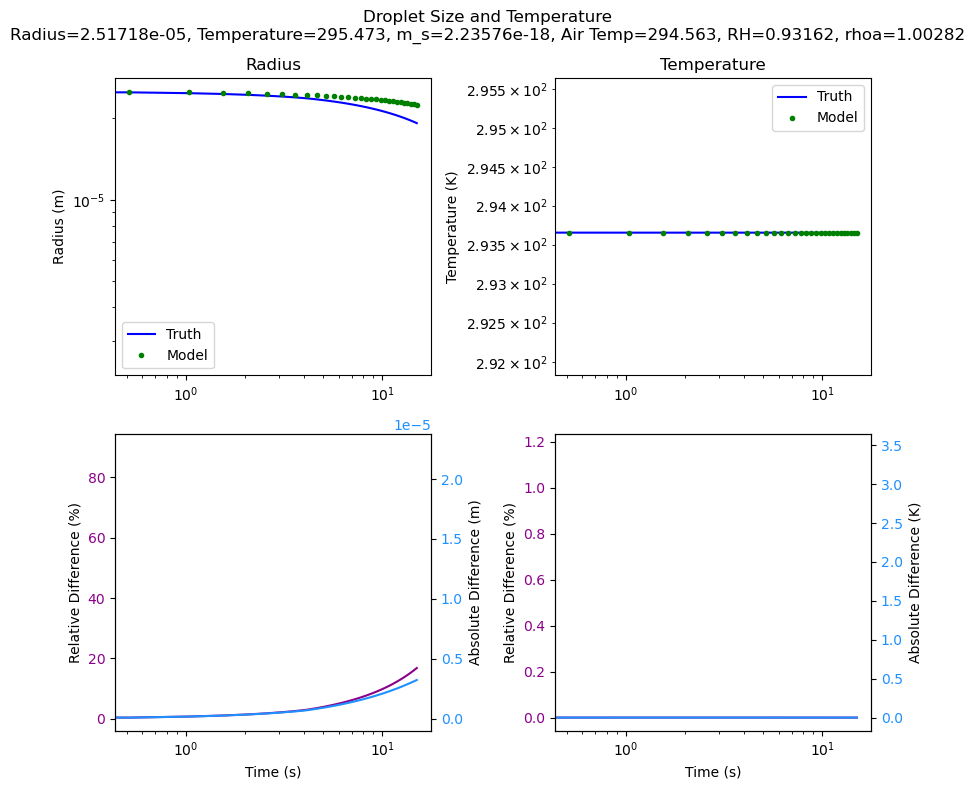

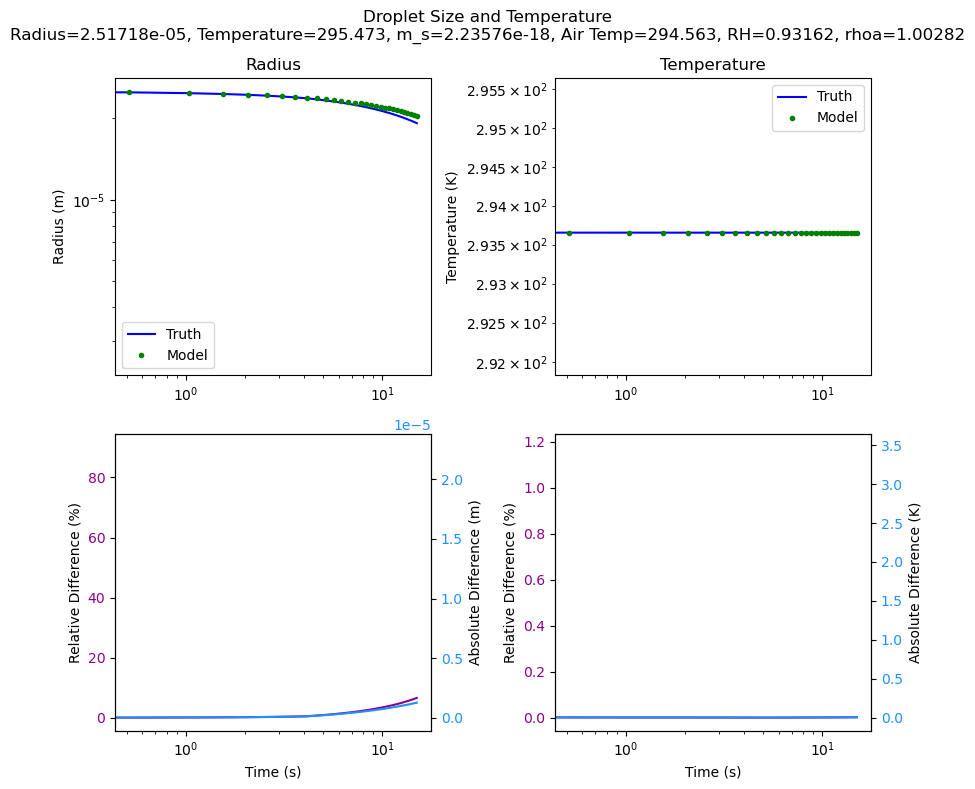

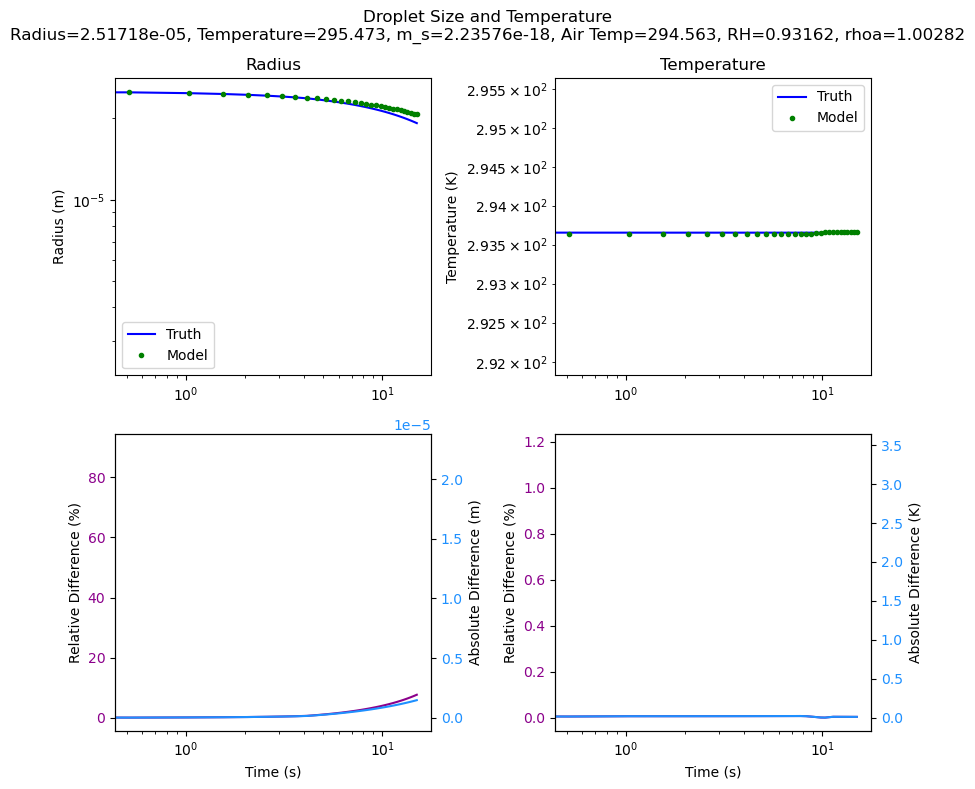

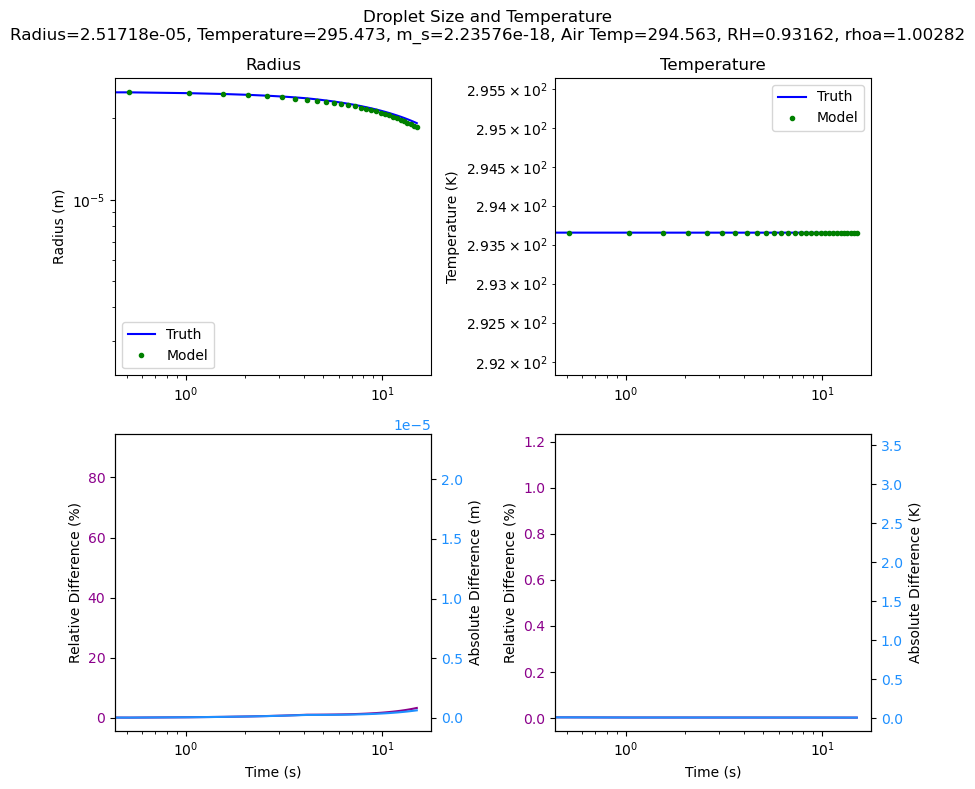

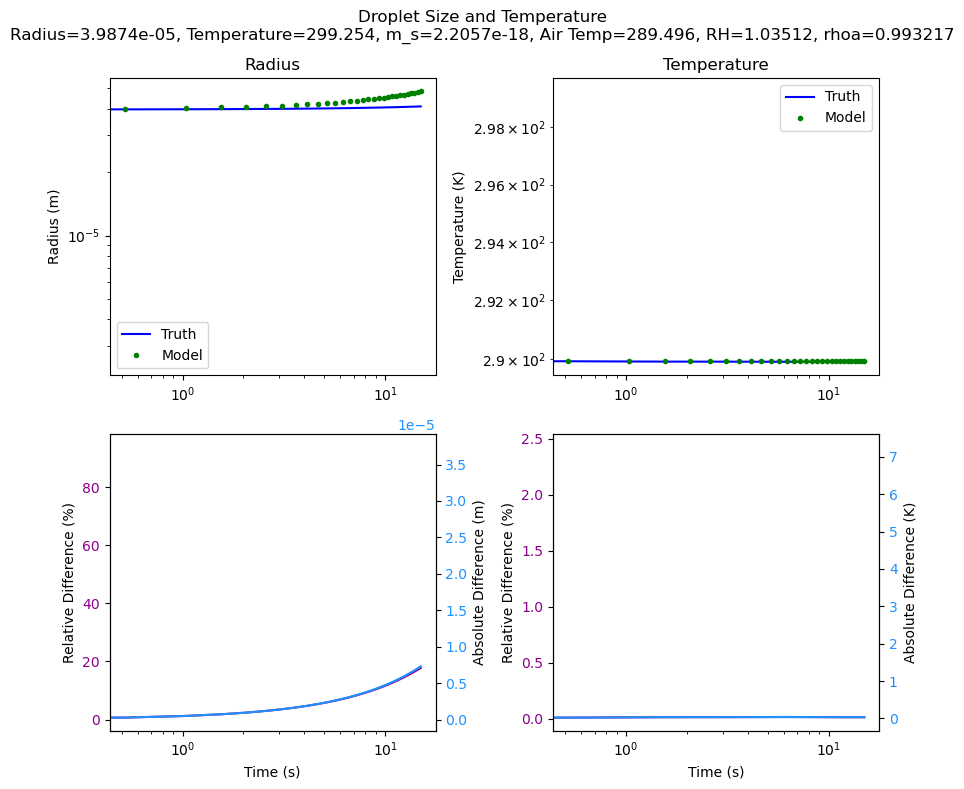

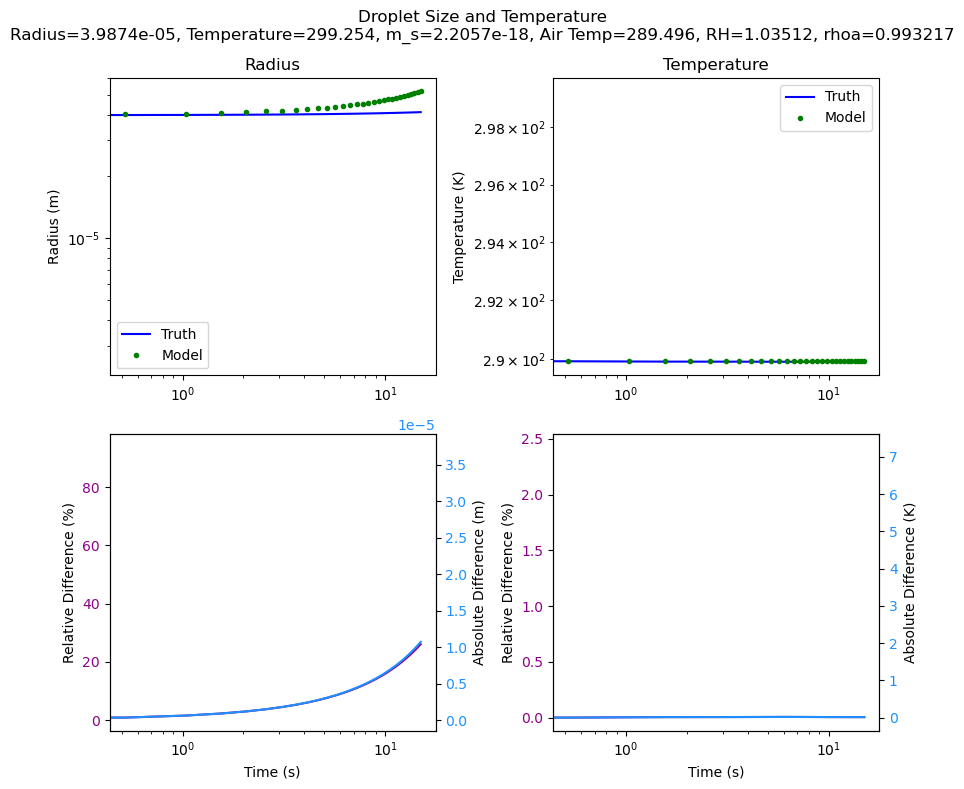

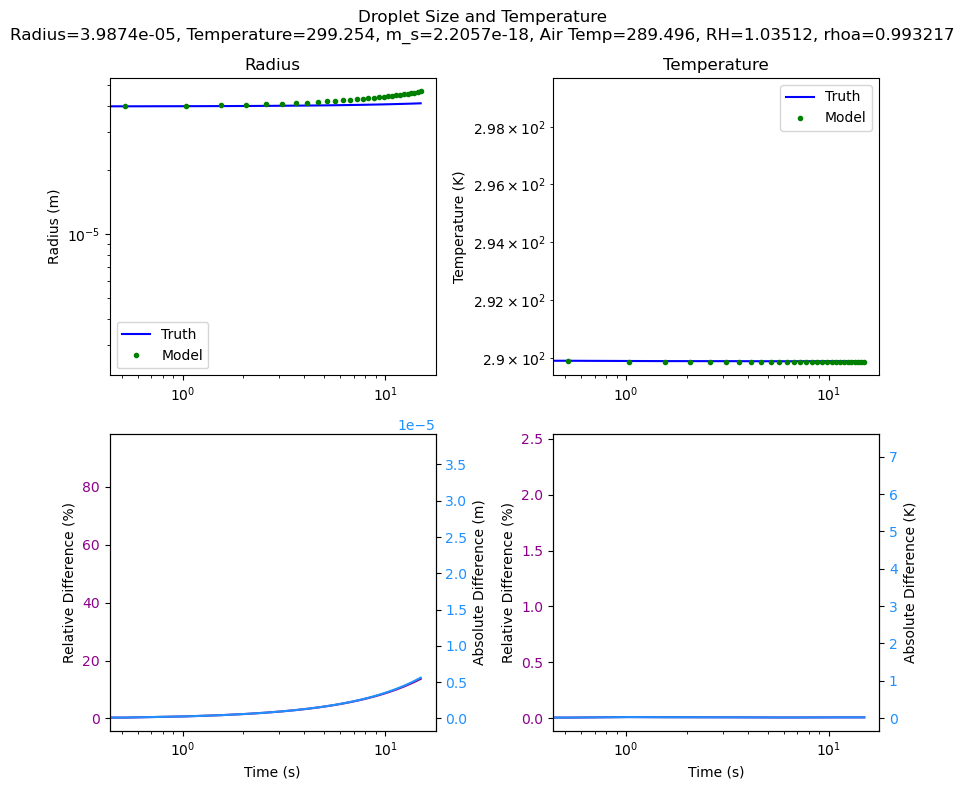

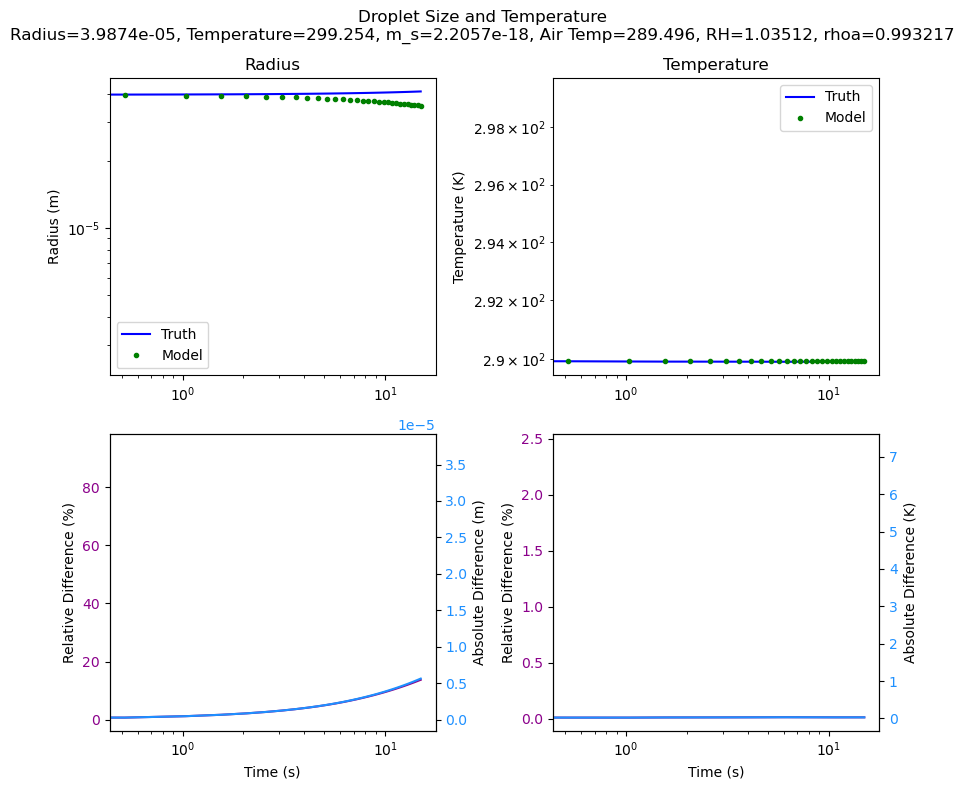

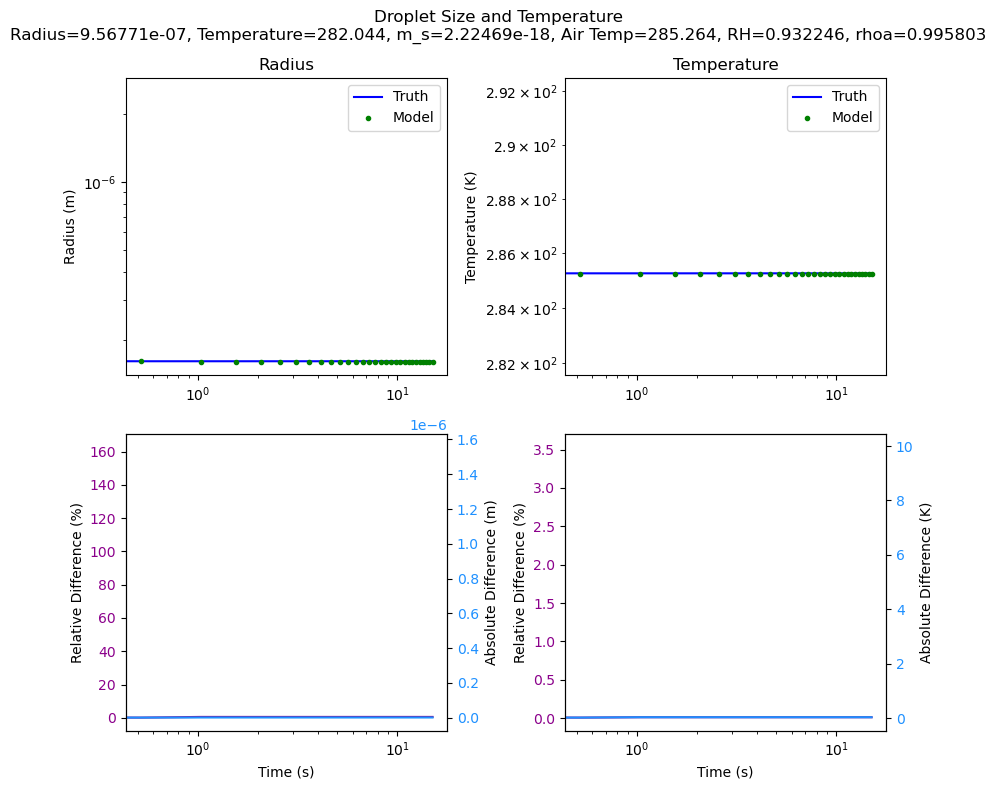

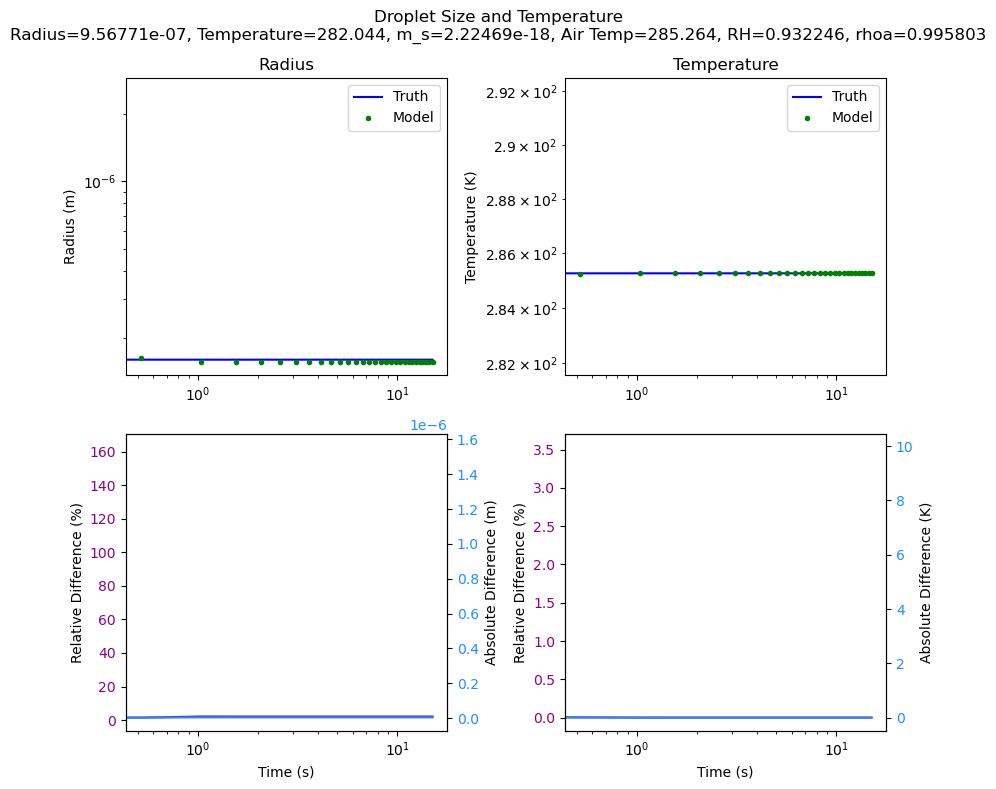

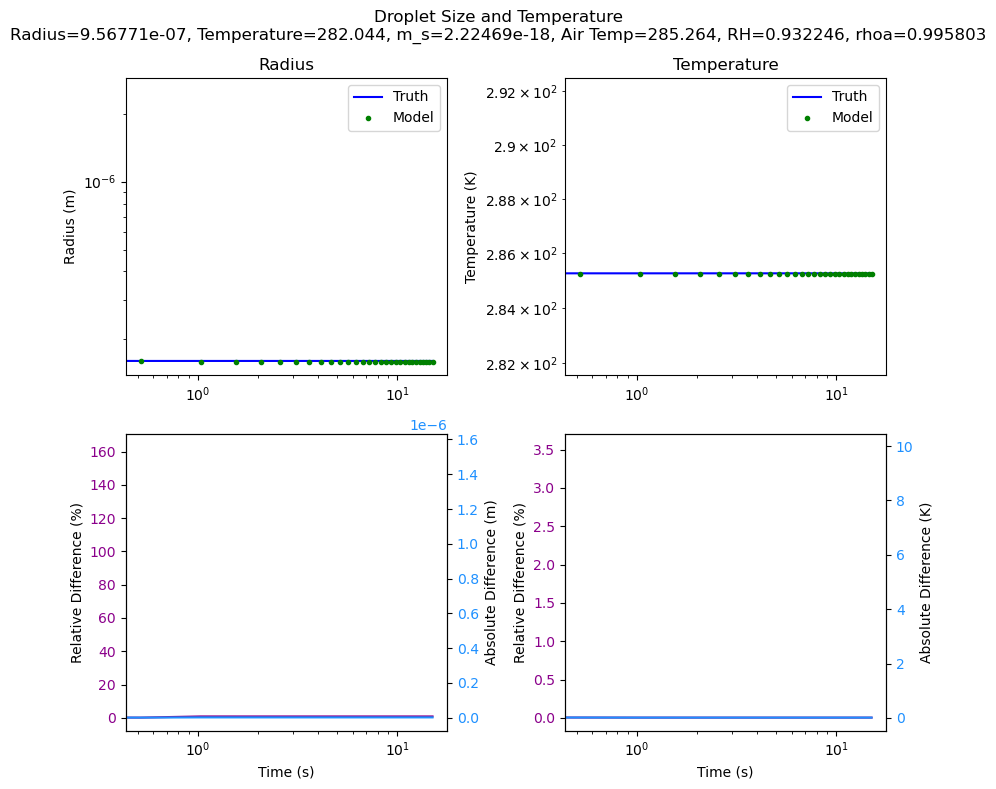

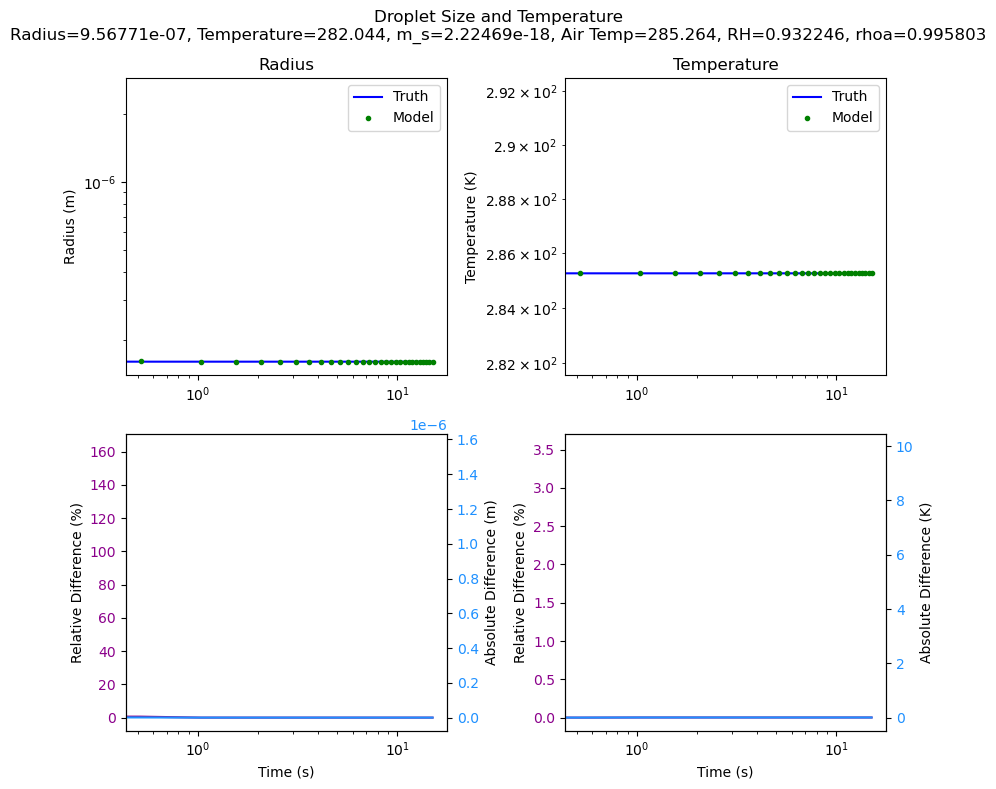

In [7]:

graph_count = 3
dt = 0.5
final_time = 15.0

for i in range(graph_count):
    input_parameters = scale_droplet_parameters(np.array( np.random.uniform( low = -1.0, high = 1.0, size=(1,6)).astype( "float32" )))[0]
    for j in range(model_count):
        print(models)
        print(j)
        analyze_model_iterative_performance(models[j], input_parameters, dt, final_time=final_time)

In [ ]:
testing_data_file = "../data/testing_data.data"

losses = mse_score_models(models,testing_data_file, "cpu")
rankings = np.argsort(losses)

print("Models sorted best to worst:\n")
for i in range(model_count):
    print("Loss for " + model_names[rankings[i]] + ": ", losses[rankings[i]])

Modles sorted best to worst:

Loss for network_400m_weighted:  0.010210113525390625
Loss for network_400m:  0.011007287693023681
Loss for network_400m_jagged_weighted:  0.011735770988464355
Loss for network_400m_jagged:  0.014196097278594971
